<a href="https://colab.research.google.com/github/NaviaEddy/SIS421_LAB08/blob/main/LAB08_NaviaCondoriEddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Evaluating Generative Models

We are going to practice how to evaluate generative models.
The evaluation method is not limited to diffusion models, in fact, deep generative models such as GAN and Flow use this method widely.

<span style="color:red">It is necessary to have a GPU to complete LAB2.</span><br>
<span style="color:red">Its efficacy will not affect your completion of this lab. Colab free plan also works.</span>

## Install Packages

Install `torch`, `torchvision` and `pytorch_gan_metrics`.

- Colab

    Use system default `torch` and `torchvision` to avoid hardware incompatibility.
    ```
    pip install pytorch_gan_metrics
    ```

- Custom environment (include `conda` users)

    Install all packages from pypi.
    ```
    pip install torch torchvision pytorch_gan_metrics
    ```

In [1]:
!pip install pytorch_gan_metrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
!pip install torch torchvision pytorch_gan_metrics

/bin/bash: line 1: pip install torch torchvision pytorch_gan_metrics: command not found


In [3]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 622.1 kB/s eta 0:00:00


In [4]:
from torchvision import transforms, datasets
from IPython.display import display
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import os
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import einops
from torchvision.utils import save_image,make_grid

In [5]:
print(torch.__version__)
print(torch.version.cuda)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

2.2.1+cu121
12.1


In [24]:
BATCH_SIZE = 126
IMG_SIZE = 28
CHANNEL = 3
EPOCH = 300
SIZE = 20
lr = 0.001
MODEL_DIR = '.\\model_weight\\'
root_train = '.\\train\\'

save_dir = os.path.join(MODEL_DIR)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Building the Diffusion Model

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

### Key Takeaways:
+ The noise-levels/variances can be pre-computed
+ There are different types of variance schedules
+ We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
+ No model is needed in this forward step

$$
q( x_t | x_0 ) = N( x_t; \sqrt{{\alpha}_t}x_t, (1-{\alpha}_t)I )
$$

In [7]:
# DDPM class
# class DDPM(nn.Module):
#     def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(3, 28, 28)):
#         super(DDPM, self).__init__()
#         self.n_steps = n_steps
#         self.device = device
#         self.image_chw = image_chw
#         self.network = network.to(device)
#         self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
#             device)  # Number of steps is typically in the order of thousands
#         self.alphas = 1 - self.betas
#         self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

#     def forward(self, x0, t, eta=None):
#         # Make input image more noisy (we can directly skip to the desired step)
#         n, c, h, w = x0.shape
#         a_bar = self.alpha_bars[t]

#         if eta is None:
#             eta = torch.randn(n, c, h, w).to(self.device)

#         noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
#         return noisy

#     def backward(self, x, t):
#         # Run each image through the network for each timestep t in the vector t.
#         # The network returns its estimation of the noise that was added.
#         return self.network(x, t)

class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(3, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        return self.network(x, t)

## Show Images Functions

In [8]:
def show_tensor_image(image, save, idx=0):
    reverse_transforms = transforms.Compose([
        #transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW a HWC
    ])

    # Tomar la primera imagen del lote
    if len(image.shape) == 4:
        image = image[idx, :, :, :]
    if save == False:
        adjusted_image = image.clamp(0, 1)
        img = reverse_transforms(adjusted_image)
        plt.imshow(img)
        return image
    else:
        print("no entro")
        return image

# Función para mostrar el proceso de difusión hacia adelante
def show_forward(ddpm, loader, device):
    # Mostrar el proceso hacia adelante
    for batch in loader:
        imgs = batch
        num_images = 6
        idx = 0
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        for percent in [0.0, 0.1, 0.2, 0.5, 0.7, 1]:
            plt.subplot(1, num_images + 1, idx + 1)
            if percent == 0.0:
                show_tensor_image(imgs, False)
            else:
                show_tensor_image(ddpm(imgs.to(device),
                    [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]).detach().cpu(), False)
            idx += 1
        break
    plt.show()

def generate_new_images(ddpm, n_samples=16, device=None, c=3, h=28, w=28,process=False):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    images = []
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        if process == True:
            tmp = torch.zeros((n_samples, c, h, w), dtype=torch.float32).to(device)
            images = tmp.detach().cpu()

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)
        steps = int(ddpm.n_steps/6)
        #print('steps:', steps)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
            if process and (idx ==0 or (idx+1) % steps==0) :
                images=torch.cat((images,x.detach().cpu()),0)
                #images.append(x)
        if process:
            return images
    #print(x.shape)
    return x

### Load Data set and observation

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import zipfile

# Ruta al archivo zip que deseas descomprimir
zip_file_path = '/content/drive/MyDrive/SIS421/LAB_8/Turtle_28.zip'

# Directorio de destino donde se extraerán los archivos
extract_dir = '/content/zip_extraido'

# Crear el directorio de destino si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("¡Descompresión completada!")

¡Descompresión completada!


In [11]:
import glob
# Definir la transformación
transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)
])

# Cargar los datos de entrenamiento
train_data = []
for im_path in glob.glob("/content/zip_extraido/*.png"):
    image = Image.open(im_path)
    image = transform(image)
    train_data.append(image)
print(len(train_data))

1934


In [12]:
train_data[0]

tensor([[[-0.7882, -0.7725, -0.7569,  ..., -0.8196, -0.8118, -0.8275],
         [-0.7961, -0.7882, -0.7725,  ..., -0.8196, -0.8275, -0.8353],
         [-0.7804, -0.7882, -0.7725,  ..., -0.8275, -0.8353, -0.8588],
         ...,
         [-0.7020, -0.6863, -0.7098,  ..., -0.6784, -0.6941, -0.7333],
         [-0.6941, -0.6941, -0.7020,  ..., -0.7098, -0.7333, -0.7490],
         [-0.6549, -0.6471, -0.6471,  ..., -0.7098, -0.7333, -0.7412]],

        [[ 0.2314,  0.2471,  0.2549,  ...,  0.1294,  0.1059,  0.0824],
         [ 0.2392,  0.2549,  0.2706,  ...,  0.1373,  0.1216,  0.0902],
         [ 0.2471,  0.2627,  0.2784,  ...,  0.1373,  0.1216,  0.0980],
         ...,
         [ 0.1922,  0.2235,  0.1294,  ..., -0.1608, -0.1451, -0.2314],
         [ 0.1843,  0.1529,  0.1294,  ..., -0.2000, -0.2078, -0.2549],
         [ 0.2157,  0.2392,  0.2706,  ..., -0.2235, -0.2549, -0.2627]],

        [[ 0.8824,  0.8980,  0.9137,  ...,  0.8039,  0.7882,  0.7647],
         [ 0.8902,  0.9059,  0.9216,  ...,  0

In [25]:
data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )

In [26]:
print(train_data[0].shape)# CHW

torch.Size([3, 28, 28])


## Training Model

In [15]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [16]:
class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        if self.normalize:
            out = self.ln(x)
        else:
            out = x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [27]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, image_channels=3):
        super(UNet, self).__init__()
        down_channels = (image_channels,16, 32, 64)
        up_channels = (128 ,64, 32, 16)
        size = (28, 14, 7)
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, down_channels[0])
        self.b1 = self._make_conv(down_channels[0], down_channels[1] ,down_channels[1], size[0] )
        self.down1 = nn.Conv2d(down_channels[1], down_channels[1], 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, down_channels[1])
        self.b2 = self._make_conv(down_channels[1], down_channels[2] ,down_channels[2], size[1] )
        self.down2 = nn.Conv2d(down_channels[2], down_channels[2], 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, down_channels[2])
        self.b3 = self._make_conv(down_channels[2], down_channels[3] ,down_channels[3], size[2] )
        self.down3 = nn.Sequential(
            nn.Conv2d(down_channels[3], down_channels[3], 2, 1),
            nn.ReLU(),
            nn.Conv2d(down_channels[3], down_channels[3], 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, down_channels[3])
        self.b_mid = nn.Sequential(
            Block((down_channels[3], 3, 3), down_channels[3], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[3])
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, up_channels[0])
        self.b4 = self._make_conv(up_channels[0], up_channels[1] ,up_channels[2], size[2] )

        self.up2 = nn.ConvTranspose2d(up_channels[2], up_channels[2], 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, up_channels[1])
        self.b5 = self._make_conv(up_channels[1], up_channels[2] ,up_channels[3], size[1] )

        self.up3 = nn.ConvTranspose2d(up_channels[3], up_channels[3], 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, up_channels[2])
        self.b_out = self._make_conv(up_channels[2], up_channels[3] ,up_channels[3], size[0] )
        self.conv_out = nn.Conv2d(up_channels[3], 3, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 16, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 32, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 64, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 64, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 128, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 32, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 64, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 16, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 32, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        out = self.conv_out(out)
        #print('Network:',out.shape)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def _make_conv(self, in_c, mid_c, out_c, size, normalize=True ):
        return nn.Sequential(
            Block((in_c, size, size), in_c, mid_c),
            Block((mid_c, size, size), mid_c, out_c),
            Block((out_c, size, size), out_c, out_c,normalize=normalize)
        )
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device).to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Setting noise to training image

<ipython-input-8-a0c13ab4ada7>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, idx + 1)


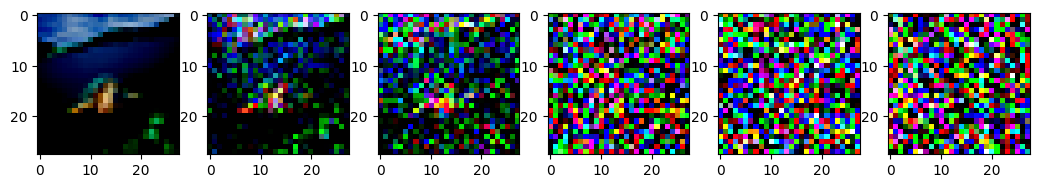

In [18]:
# Optionally, show the diffusion (forward) process
#for step, batch in enumerate(data_loader):
show_forward(model, data_loader, device)

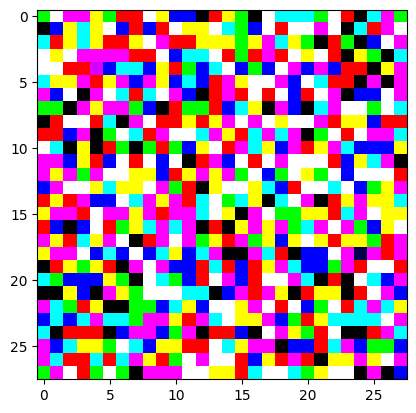

In [19]:
generated = generate_new_images(model,n_samples=1)
img = show_tensor_image(generated.detach().cpu(),False)

### Show the denoising (backward) process

In [22]:
from torch.optim import Adam
train_hist = {}
train_hist['loss'] = []
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
mse = nn.BCELoss()
best_loss = float("inf")
n_steps = model.n_steps
epochs = EPOCH # Try more!
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance
for epoch in range(epochs):
    data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )
    optimizer.param_groups[0]['lr'] = lr*(1-epoch/epochs)
    epoch_loss = 0.0
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()

      #t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      #print('batch:', batch.shape)
      x = batch.to(device)
      n = len(x)
      # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
      eta = torch.randn_like(x).to(device)
      t = torch.randint(0, n_steps, (n,)).to(device)
      # Computing the noisy image based on x0 and the time-step (forward process)
      noisy_imgs = model(x, t, eta)

      if noisy_imgs.shape[1] == 1:  # Si el modelo produce imágenes en escala de grises
        noisy_imgs = torch.cat([noisy_imgs] * 3, dim=1)
      # Getting model estimation of noise based on the images and the time-step
      eta_theta = model.backward(noisy_imgs, t.reshape(n, -1))
      #print(eta_theta.shape,eta.shape)
      loss = mse(eta_theta, eta)
      train_hist['loss'].append(loss.item())
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * len(x) / len(data_loader.dataset)
    if epoch % 5 == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      img=generate_new_images(model,n_samples=4, device=device)
      #, f"Images generated at epoch {epoch + 1}"
      show_tensor_image(img.detach().cpu(),False)
      plt.title(f"Images generated at epoch {epoch + 1}")
      plt.show()
    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'testing.pt'))
        log_string += " --> Best model ever (stored)"
    print(log_string)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.save(model.state_dict(), os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt'))

## Denoising image

8


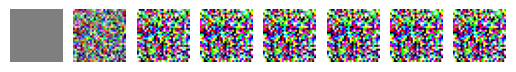

In [ ]:
# Denoising
model.load_state_dict(torch.load(os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt')))
imgs=generate_new_images(model,n_samples=1, device=device,process=True)
      #, f"Images generated at epoch {epoch + 1}"
print(len(imgs))
for idx,img in enumerate(imgs):
      plt.subplot(1, 7 + 1, idx + 1)
      show_tensor_image(img.detach().cpu(),False)

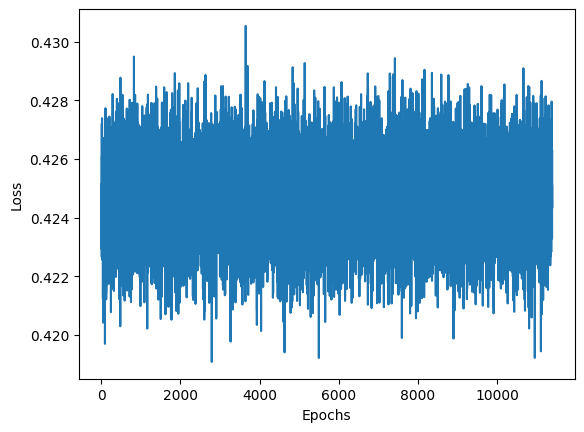

In [ ]:
fig = plt.figure()
plt.plot(train_hist['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Generating Images
- Use `torch` to generate some noise as images.
- Use `torchvision.utils.save_image` to save `torch.Tensor` as an `png` image file.

In [ ]:
#model.load_state_dict(torch.load(os.path.join(save_dir, 'new_diffusion_model_100_epoch_best_29.pt')))
#model.to(device)
@torch.no_grad()
def plot_result_image():
    # Sample noise
    num_images = 10000
    os.makedirs('/content/zip_extraido', exist_ok=True)
    for j in range(num_images):
        path = os.path.join(f'/content/zip_extraido/{j+1:05d}.png')
        image = generate_new_images(model, n_samples=1, device=device)
        image = image.squeeze().detach().cpu()  # Eliminar dimensiones unitarias y mover a CPU
        image = image.permute(1, 2, 0)  # Cambiar orden de dimensiones a HWC
        image = (image + 1) / 2  # Desnormalizar la imagen si es necesario
        print(f'Saving {j+1:05d}.png')
        save_image(image, path)

plot_result_image()

Saving 00001.png


TypeError: Cannot handle this data type: (1, 1, 28), |u1

## Evaluate Generated Images at Runtime
- Use `torchvision.io.read_image` to load all images into memory one by one.
- Use `pytorch_gan_metrics.get_fid` to calculate FID between generated images in `./images` and our dataset (`mnist.npz`).

    The following is the document about how to use `get_fid` for reference.
    ```python
    from pytorch_gan_metrics import get_fid

    images = ...                                    # [N, 3, H, W] normalized to [0, 1]
    FID = get_fid(images, 'path/to/statistics.npz') # Frechet Inception Distance
    ```

The output FID should be the same as Checkpoint 2 (round to two decimal places).

In [ ]:
from pytorch_gan_metrics import get_fid
from torchvision.io import read_image
num_images = 10000
images = []
for i in range(num_images):
    path = os.path.join(f'./images/{i+1:05d}.png')
    image = read_image(path) / 255.
    images.append(image)
images = torch.stack(images, dim=0)
FID = get_fid(images,'./mnist.npz')
print(f'{FID:.5f}')

---

## Use `torchvision` to Save Grid Images

In [ ]:
for i in range(8):
    print('Images idx: ',i)
    imgs = generate_new_images(model,n_samples=1, device=device,process=True)
    #print(imgs.shape)
    imge=show_tensor_image(imgs.detach().cpu(),True)
    #save_image(imge,'tmp.png')
    if i == 0:
        grid_imgs=imgs
    else:
        grid_imgs=torch.cat((grid_imgs,imgs),0)
    #print(grid_imgs.shape)


In [ ]:
from PIL import Image
images = []
os.makedirs('./result', exist_ok=True)
for i in range(64):
    save_image( grid_imgs[i, :, :, :] ,f'./result/tmp_{i}.png',nrow=8,normalize=True)

result_data = []
transform_result=transforms.ToTensor()
for i in range(8):
    for j in range(8):
        im_path = f'./result/tmp_{i+8*j}.png'
        x =transform_result(Image.open(im_path))
        #print(x.shape)
        result_data.append( transform_result(Image.open(im_path)))

In [ ]:
from IPython.display import Image, display

img = make_grid(result_data)
save_image(img,'tmp.png', normalize=True)
display(Image(filename='tmp.png'))